pandas-ylt
==========

Python modules for working in pandas with various loss data tables used for CAT modelling


### Read the example YLT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas_ylt.layer import Layer
from pandas_ylt import YearLossTable, YearEventLossTable

pd.api.extensions.register_dataframe_accessor("yel")(YearEventLossTable)
pd.api.extensions.register_dataframe_accessor("yl")(YearLossTable)

yelt = pd.read_csv("tests/_data/example_pareto_poisson_yelt.csv",
                   index_col=['Year', 'EventID', 'DayOfYear'])['Loss']
yelt.attrs['n_yrs'] = 1e5

display(yelt.yel.to_rp_summaries([1000, 200, 100, 10], is_ef=False).unstack(
    'Metric').style.format("{:,.0f}"))
display(yelt.yel.to_summary_stats_series().to_frame().style.format("{:,.0f}"))

Metric,AEP,OEP
ReturnPeriod,,
1000,"494,221","494,221"
200,"104,018","101,450"
100,"51,611","49,340"
10,"5,539","4,708"


,Loss
Metric,
AAL,"5,564"
STD,"158,881"


### Applying an example reinsurance tower to the losses

In [2]:
layers = {
    # Layers at 20,000 increments with 1 reinstatement
    "20 xs 20 (1@100)": Layer(
            **{"limit": 20000, "xs": 20000, "agg_limit": 40000.0, "reinst_at": 1.0,
               "premium": 2000}
    ),
    "20 xs 40 (1@100)": Layer(
            **{"limit": 20000, "xs": 40000, "agg_limit": 40000.0, "reinst_at": 1.0,
               "premium": 1000}
    ),
    "20 xs 60 (1@0)": Layer(
            **{"limit": 20000, "xs": 60000, "agg_limit": 40000.0, "reinst_at": 0.0,
               'premium': 400}
    ),
    "20 xs 80 (Single Shot)": Layer(
            **{"limit": 20000, "xs": 80000, "agg_limit": 20000.0, "reinst_at": 0.0,
               "premium": 400}
    ),
}

### Get the summary stats for each layer

In [3]:
# Get a separate YLT for each layer
lyr_ylts = pd.concat({lyr: layers[lyr].ceded_ylt(yelt) for lyr in layers},
                     names=['LayerName'])
lyr_reinst = pd.concat({lyr: layers[lyr].ceded_ylt(yelt, only_reinstated=True) for lyr in layers},
                       names=['LayerName'])

# Calculate the layer stats from the YLTs
summary_stats = {k:
                     {'AAL': lyr_ylts.loc[k].yl.aal,
                      'STD': lyr_ylts.loc[k].yl.std(),
                      'AvgReinstLimit': lyr_reinst.loc[k].yl.aal,
                      'AttachRP': 1 / lyr_ylts.loc[k].yl.prob_of_a_loss,
                      'OccLimitRP': 1 / lyr_ylts.loc[k].yl.loss_exprob(layers[k].limit),
                      'ExhaustRP': 1 / lyr_ylts.loc[k].yl.loss_exprob(layers[k].agg_limit),
                      'Premium+RiP': layers[k].premium + layers[k].reinst_rate * lyr_reinst.loc[k].yl.aal,
                      }
                 for k in layers}

# Display the results
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}",
                                            'STD': '{:,.0f}',
                                            'AvgReinstLimit': '{:.2f}',
                                            'AttachRP': "{:,.0f}",
                                            'OccLimitRP': "{:,.0f}",
                                            'ExhaustRP': "{:,.0f}",
                                            })

,AAL,STD,AvgReinstLimit,AttachRP,OccLimitRP,ExhaustRP,Premium+RiP
20 xs 20 (1@100),336,"2,439",334.05,41,82,"16,667",2033.404714
20 xs 40 (1@100),201,"1,934",199.88,82,121,"50,000",1009.993836
20 xs 60 (1@0),144,"1,656",144.01,121,161,"100,000",400.000000
20 xs 80 (Single Shot),114,"1,481",0.00,161,196,196,400.000000


In [4]:
# Get a separate YELT for each layer
lyr_yelts = pd.concat({lyr: layers[lyr].ceded_yelt(yelt) for lyr in layers}, names=['LayerName'])
lyr_event_reinst = pd.concat({lyr: layers[lyr].ceded_yelt(yelt, only_reinstated=True) for lyr in layers}, names=['LayerName'])
# lyr_yelts

# Calculate the layer stats from the YLTs
summary_stats = {k:
                     {'AAL': lyr_yelts.loc[k].yel.aal,
                      'STD': lyr_yelts.loc[k].yel.to_ylt().yl.std(),
                      'AvgReinstLimit': lyr_event_reinst.loc[k].yel.aal,
                      'AttachRP': 1 / lyr_yelts.loc[k].yel.to_ylt().yl.prob_of_a_loss,
                      'OccLimitRP': 1 / lyr_yelts.loc[k].yel.to_ylt().yl.loss_exprob(layers[k].limit),
                      'OccLimitRP (Single Event)': 1 / lyr_yelts.loc[k].yel.to_ylt(is_occurrence=True).yl.loss_exprob(layers[k].limit),
                      'ExhaustRP': 1 / lyr_yelts.loc[k].yel.to_ylt().yl.loss_exprob(layers[k].agg_limit),
                      }
                 for k in layers}

# Display the results to check the same as before
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}", 'STD': '{:,.0f}',
                                            'ExpReinst': '{:.1f}',
                                            'AttachRP': "{:,.0f}",
                                            'OccLimitRP': "{:,.2f}",
                                            'OccLimitRP (Single Event)': "{:,.2f}",
                                            'ExhaustRP': "{:,.0f}",
                                            })

,AAL,STD,AvgReinstLimit,AttachRP,OccLimitRP,OccLimitRP (Single Event),ExhaustRP
20 xs 20 (1@100),336,"2,439",334.047141,41,81.70,81.83,"16,667"
20 xs 40 (1@100),201,"1,934",199.876713,82,120.92,120.92,"50,000"
20 xs 60 (1@0),144,"1,656",144.014744,121,160.51,160.51,"100,000"
20 xs 80 (Single Shot),114,"1,481",0.000000,161,195.69,196.08,196


Calculate the YLTs net of reinstatement costs. The AAL to the layer is reduced because reinst premiums offset the loss.

Get the net and final net EP curve

In [5]:
rip_yelt = lyr_event_reinst.multiply(
        pd.Series({k: layers[k].reinst_rate for k in layers}).rename_axis('LayerName')).rename('Loss')

retained_yelt = yelt.subtract(
    lyr_yelts.groupby(yelt.index.names).sum(), fill_value=0.0)

net_rip_yelt = retained_yelt.add(rip_yelt.groupby(yelt.index.names).sum(),
    fill_value=0.0)

combined_rp_curves = pd.concat([
    df.yel.to_rp_summary([500, 250, 200, 150, 100, 75, 50, 25, 10], is_ep=True,
                         is_occurrence=True).rename(name)
    for name, df in
    [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]
], axis=1)

display(combined_rp_curves.style.format("{:,.0f}"))


,Gross,Net,Final Net
ReturnPeriod,,,
500,"272,297","192,297","195,297"
250,"123,967","43,967","46,967"
200,"101,450","21,450","24,450"
150,"75,760","20,000","23,000"
100,"49,340","20,000","22,449"
75,"36,257","20,000","21,616"
50,"24,074","20,000","20,407"
25,"12,135","12,135","12,135"
10,"4,708","4,708","4,708"


Plot the OEP

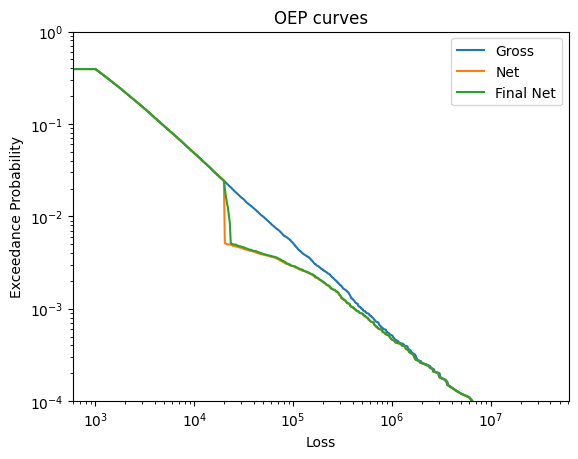

In [6]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]:
    df.yel.to_ylt(is_occurrence=True).yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax,
                                                            label=name)

ax.set(xscale='log', yscale='log', ylim=[1e-4, 1], ylabel='Exceedance Probability')
plt.title('OEP curves')
plt.show()

Plot AEP

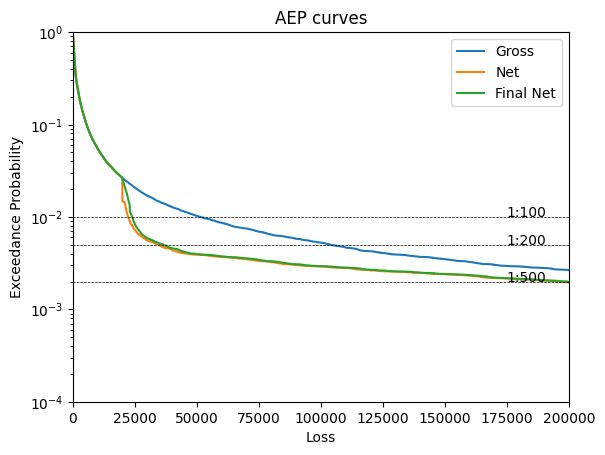

In [7]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]:
    df.yel.to_ylt().yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax, label=name)

for rp in [100, 200, 500]:
    ax.plot(ax.get_xlim(), [1 / rp, 1 / rp], '--k', linewidth=0.5)
    ax.text(1.75e5, 1 / rp, f"1:{rp}")

ax.set(yscale='log', ylim=[1e-4, 1], xlim=[0, 0.2e6], ylabel='Exceedance Probability')
plt.title('AEP curves')
plt.show()

### Simplified example numbers to show the impact on the cost of capital

In [8]:
benchmark_exprob = 1 / 200.0
capital_ratio = 2.0
capital_cost_rate = 0.08
cost_of_reins = sum([x.premium for x in layers.values()])

# Base case with no reinsurance
print("No reinsurance.")

capital_required = capital_ratio * yelt.yel.to_ylt().yl.loss_at_exprobs(
    benchmark_exprob)
capital_buffer = capital_required * (capital_ratio - 1) / capital_ratio
print(f"\tCapital Requirement: {capital_required:,.0f} for a buffer of " +
      f"{capital_buffer:,.0f} at the 1:{1 / benchmark_exprob:,.0f}")

capital_costs = capital_required * capital_cost_rate
print(f"\tCosts associated with holding the capital {capital_costs:,.0f}")

peak_loss = capital_required
print("\tReturn period for peak loss = " +
      f"{1 / yelt.yel.to_ylt().yl.loss_exprobs([peak_loss])[0]:,.0f}")

# How reinsuance changes the numbers
print("Reinsurance + same capital.")

capital_used = net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs(benchmark_exprob)
print(f"\tNow have buffer of {capital_required - capital_used - cost_of_reins:,.0f}")

print("\tReturn period for peak loss = " +
      f"{1 / net_rip_yelt.yel.to_ylt().yl.loss_exprobs(peak_loss - cost_of_reins):,.0f}")

print(f"\tCost of reins = {cost_of_reins:,.0f}")
print(f"\tCost of reins + maintinaing capital = {cost_of_reins + capital_costs:,.0f}")

# If reinsurance is used instead of capital
print("Reinsurance offsetting capital.")

new_capital_requirement = capital_buffer + capital_used
print(f"\tNew Capital Requirement: {new_capital_requirement:,.0f} for a buffer of " +
      f"{capital_buffer:,.0f}")

print("\tReturn period for peak loss = " +
      f"{1 / net_rip_yelt.yel.to_ylt().yl.loss_exprobs([new_capital_requirement])[0]:,.0f}")

new_peak_loss = net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs(
    benchmark_exprob) + capital_buffer

new_capital_costs = new_capital_requirement * capital_cost_rate
print(
    f"\tCost of reins + maintinaing capital = {cost_of_reins + new_capital_costs:,.0f}")



No reinsurance.
	Capital Requirement: 208,036 for a buffer of 104,018 at the 1:200
	Costs associated with holding the capital 16,643
	Return period for peak loss = 388
Reinsurance + same capital.
	Now have buffer of 167,681
	Return period for peak loss = 518
	Cost of reins = 3,800
	Cost of reins + maintinaing capital = 20,443
Reinsurance offsetting capital.
	New Capital Requirement: 140,572 for a buffer of 104,018
	Return period for peak loss = 405
	Cost of reins + maintinaing capital = 15,046


### Define some layers

In [9]:



# layers = [
#     # First loss
#     {'name': '20 xs 0', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0})},    
#     {'name': '20 xs 20', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0})},
#     {'name': '20 xs 40', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0})},
#     {'name': '20 xs 60', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0})},    
#     {'name': '20 xs 80', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0})},    
#     # Second loss
#     {'name': '20 xs 0 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},        
#     {'name': '20 xs 20 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
#     {'name': '20 xs 40 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
#     {'name': '20 xs 60 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
#     {'name': '20 xs 80 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
# ]

